# Imports and File Reads

In [1]:
import pandas as pd
import numpy as np
# from dataprep.eda import create_report
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Rename filepath prefix for your respective folder hierarchies
filepath_prefix = 'dataset\\'

df_train_users = pd.read_csv(f'{filepath_prefix}train_users_2.csv')
df_test_users = pd.read_csv(f'{filepath_prefix}test_users.csv')
df_countries = pd.read_csv(f'{filepath_prefix}countries.csv')
df_age_bkts = pd.read_csv(f'{filepath_prefix}age_gender_bkts.csv')
df_sessions = pd.read_csv(f'{filepath_prefix}sessions.csv')

# Exploratory Data Analysis

## Age Bucket Distribution
Obtained from https://www.kaggle.com/code/asmaamohy/airbnb-eda

C:\Users\pawan\AppData\Local\Temp\ipykernel_30552\4040025584.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)


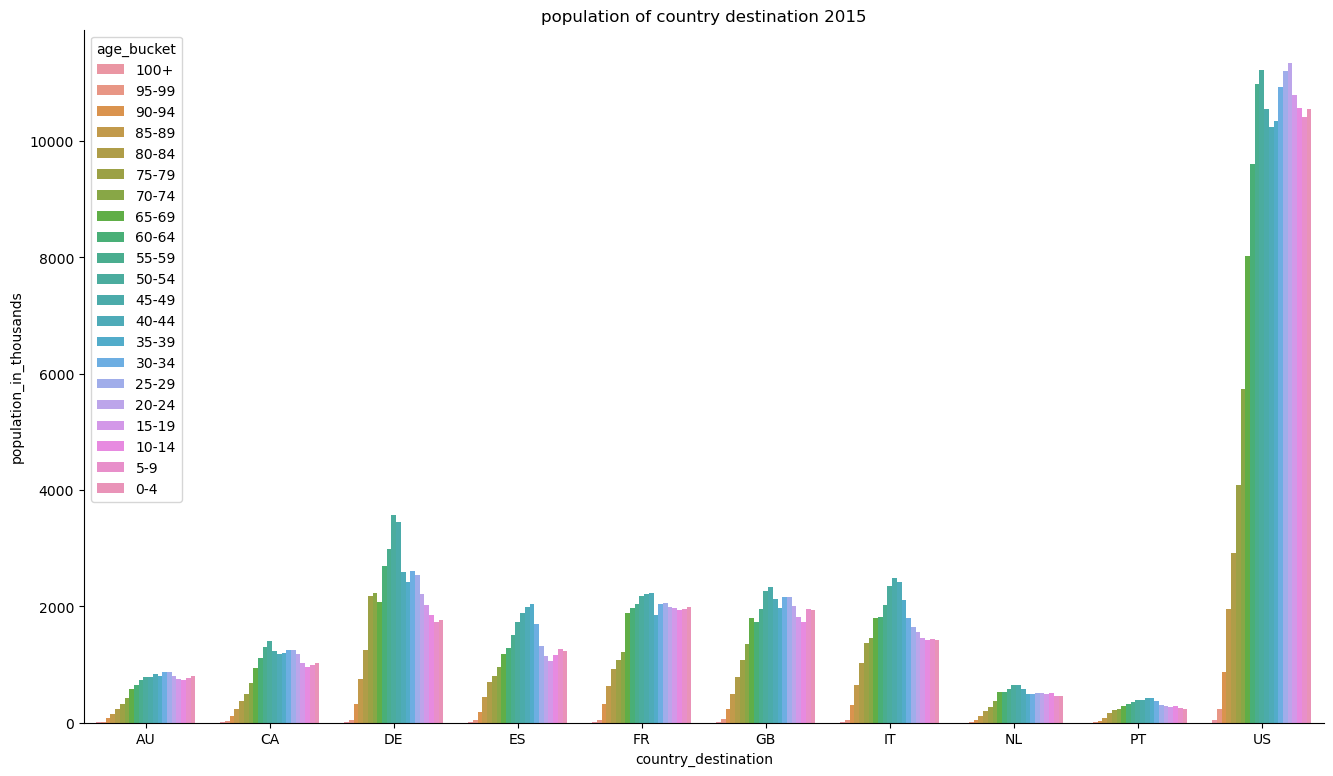

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)
plt.title('population of country destination 2015')
sns.despine()

## First Device vs Destination Country

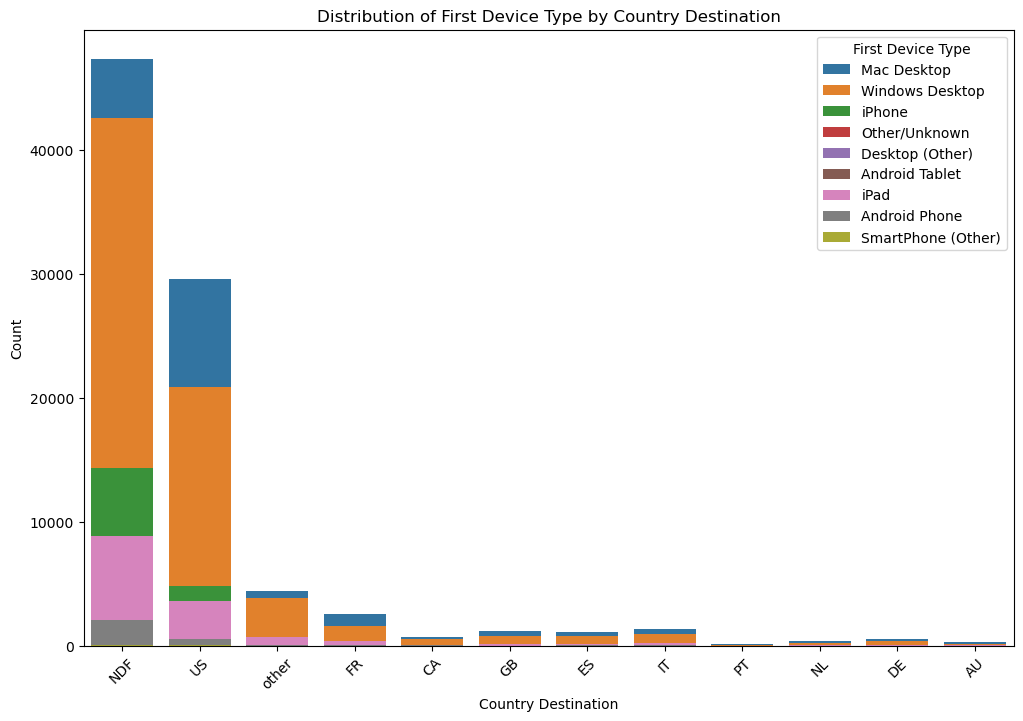

In [4]:
# Assuming df_train_users is your DataFrame
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=df_train_users, x='country_destination', hue='first_device_type', dodge=False, ax=ax)

ax.set_title('Distribution of First Device Type by Country Destination')
ax.set_ylabel('Count')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type')

plt.show()

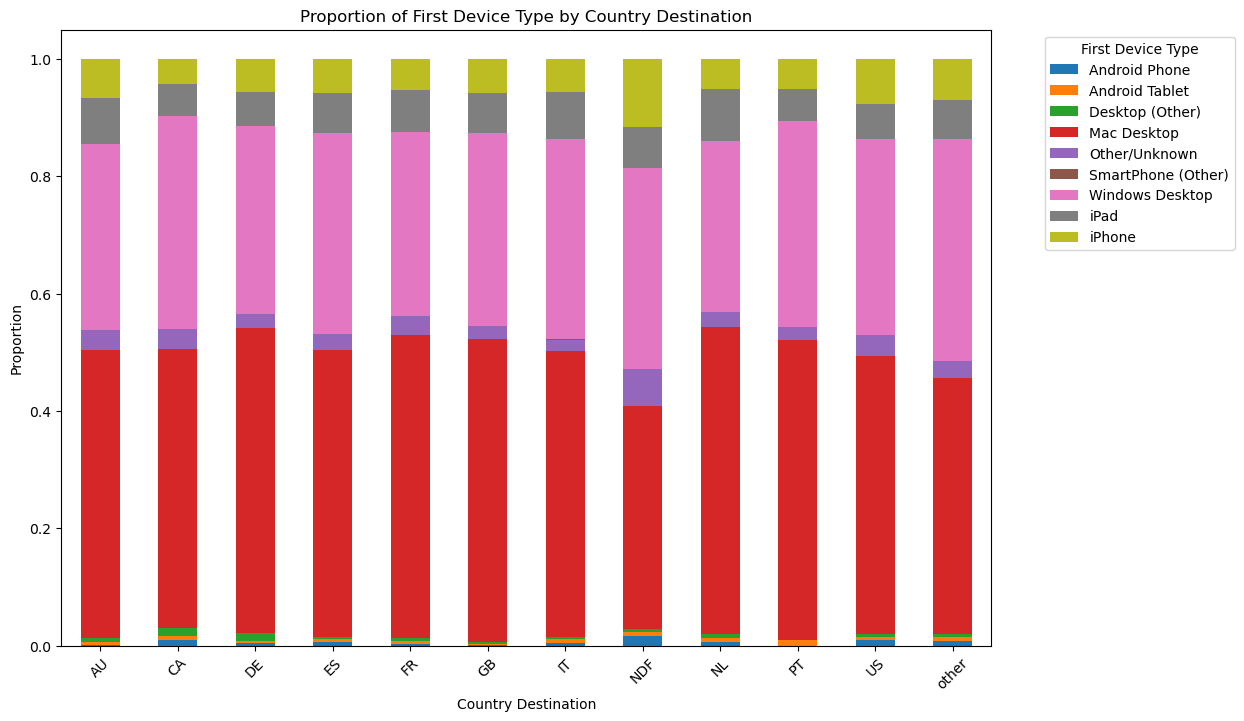

In [5]:
# Assuming df_train_users is your DataFrame
# Step 1: Calculate proportions
proportions = df_train_users.groupby(['country_destination', 'first_device_type']).size().reset_index(name='count')
total_counts = df_train_users['country_destination'].value_counts().reset_index()
total_counts.columns = ['country_destination', 'total_count']

proportions = proportions.merge(total_counts, on='country_destination')
proportions['proportion'] = proportions['count'] / proportions['total_count']

# Step 2: Create a pivot table
pivot_df = proportions.pivot_table(index='country_destination', columns='first_device_type', values='proportion', fill_value=0)

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Proportion of First Device Type by Country Destination')
ax.set_ylabel('Proportion')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Data Cleaning

In [6]:
# Drop NA

df_train_users = df_train_users.dropna()
df_train_users.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

<Axes: xlabel='age'>

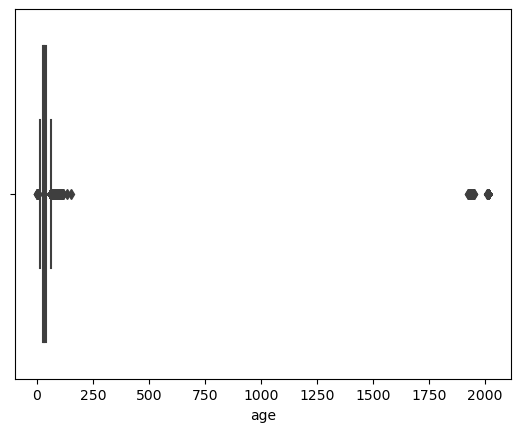

In [7]:
sns.boxplot(data=df_train_users, x='age')

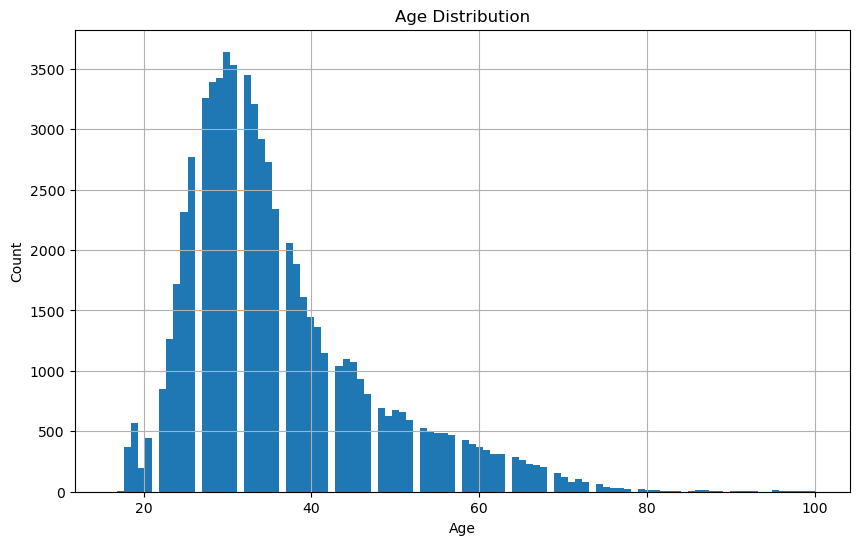

count    66858.000000
mean        36.140028
std         11.203547
min         16.000000
25%         28.000000
50%         33.000000
75%         41.000000
max        100.000000
Name: age, dtype: float64


In [8]:
# Adjust the weird ages. Seems like there are some years added to the age

ages = df_train_users['age'].copy()

ref_year = 2010 # "...users dataset dates back to 2010."
ages[(ages >= 1910) & (ages <= 1994)] = ref_year - ages[(ages >= 1910) & (ages <= 1994)]
ages[(ages < 16) | (ages > 100)] = np.nan

plt.figure(figsize=(10,6))
ages.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(ages.describe())

# replacing orginal age column with cleaned age column
df_train_users['age'] = ages

# Drop Ages < 18, it is AirBnB policy that minimum age of users should be 18

df_train_users = df_train_users[df_train_users['age'] >= 18]

# Modeling

## Ensemble Classifier

## K-Means

In [ ]:
df_train = df_train_users.drop(columns=['country_destination', 'id', 'date_account_created','date_first_booking'])

In [25]:
# Scale the numerical columns data for k-means clustering
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

# Apply StandardScaler to numerical columns
df_train[numeric_features] = scaler.fit_transform(df_train[numeric_features])

# One Hot Encode
categorical_features = df_train.select_dtypes(include='object').columns

df_train_encoded = pd.get_dummies(df_train, columns=categorical_features, drop_first=True)
df_train_encoded.info()

df_train_encoded.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66853 entries, 2 to 213445
Columns: 104 entries, timestamp_first_active to first_browser_Yandex.Browser
dtypes: float64(3), uint8(101)
memory usage: 8.5 MB


timestamp_first_active            float64
age                               float64
signup_flow                       float64
gender_FEMALE                       uint8
gender_MALE                         uint8
                                   ...   
first_browser_Sogou Explorer        uint8
first_browser_Stainless             uint8
first_browser_TenFourFox            uint8
first_browser_TheWorld Browser      uint8
first_browser_Yandex.Browser        uint8
Length: 104, dtype: object

In [27]:
# Use PCA to reduce dimensionality

pca = PCA(0.95)
df_pca = pca.fit_transform(df_train_encoded)

In [34]:
def kmeans_execution(df, num_clusters):
    # Create models & store labels for different number of clusters
    model = KMeans(n_clusters = num_clusters, n_init='auto', random_state = 0) # Create KMeans object \
    #kmeans = MiniBatchKMeans(n_clusters=k, random_state=716, batch_size=1000)
    model.fit(df_pca) # Apply to the data
    labels = model.labels_ # Capture K-Means labels
    distortion = model.inertia_ # Used for elbow method
    silhouette = silhouette_score(df, labels)
    centers = model.cluster_centers_
    return {
        'model' : model,
        'centers' : centers,
        'labels' : labels,
        'distortion' : distortion,
        'silhouette_score' : silhouette
    }
    
k_means_cluster_results = {}
num_clusters_range = range(3, 5)

for cluster in num_clusters_range:
    k_means_cluster_results[cluster] = kmeans_execution(df_pca, cluster)
    print(f"Silhouette score for {cluster} clusters = {k_means_cluster_results[cluster]['silhouette_score']}")

Silhouette score for 3 clusters = 0.2014743979949745
Silhouette score for 4 clusters = 0.18099882450650964


Silhouette score for 3 clusters = 0.2014743979949745
Silhouette score for 4 clusters = 0.18099882450650964


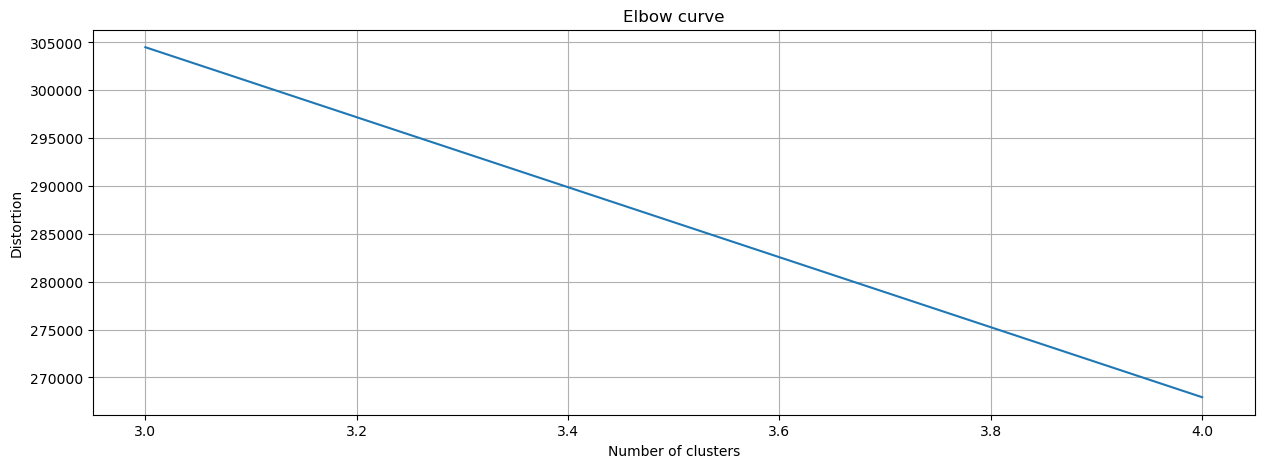

In [35]:
# Print Silhouette Score

for cluster in num_clusters_range:
    print(f"Silhouette score for {cluster} clusters = {k_means_cluster_results[cluster]['silhouette_score']}")
    
# Extracting distortions for different k values
distortions = [k_means_cluster_results[cluster]['distortion'] for cluster in num_clusters_range]

fig = plt.figure(figsize=(15, 5))
plt.plot(num_clusters_range, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

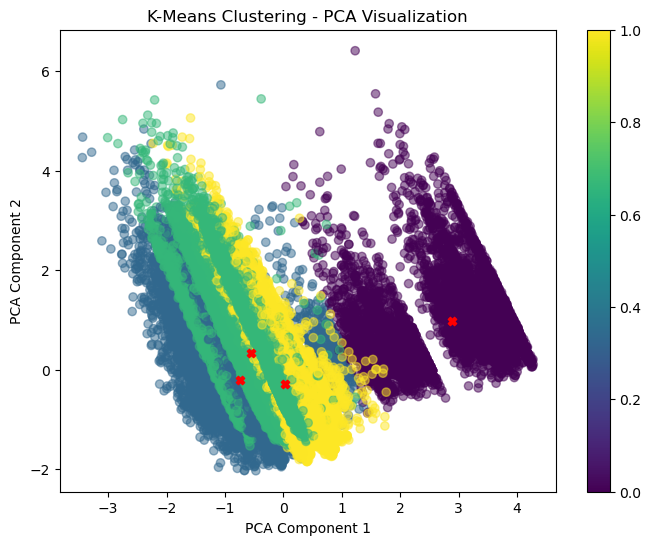

In [36]:
# Visualize clusters in PCA space
ideal_cluster_size = 4

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=k_means_cluster_results[ideal_cluster_size]['labels'], cmap='viridis', alpha=0.5, label='Data points')
plt.scatter(k_means_cluster_results[ideal_cluster_size]['centers'][:,0], k_means_cluster_results[ideal_cluster_size]['centers'][:,1], c='red', marker='X', label='Cluster Centers')
plt.title('K-Means Clustering - PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()